Задача:
Воспроизвести динамику гауссого свободного волнового пакета в координатном представлении на конечном промежутке. Сравнить с точным решением, пронаблюдать отражение от границ и подавить подобрав маскировочную функцию.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import factorial
from scipy.linalg import inv as Inv
from scipy.linalg import eig
from scipy.sparse import diags
import time


maxIterNumber = 100000

def arnoldi_iteration(A, b, n: int):
    eps = 1e-12
    h = np.zeros((n + 1, n))
    Q = np.zeros((A.shape[0], n + 1))
    # Normalize the input vector
    Q[:,0] = b / np.linalg.norm(b, 2)   # Use it as the first Krylov vector
    for k in range(1, n + 1):
        v = np.dot(A, Q[:, k - 1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j, k - 1] = np.dot(Q[:,j].T, v)
            v = v - h[j, k - 1] * Q[:,j]
        h[k, k - 1] = np.linalg.norm(v, 2)
        if h[k, k - 1] > eps:  # Add the produced vector to the list, unless
            Q[:,k] = v / h[k, k - 1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h


def matrixExponent(matr, isDiagonal=False, isTridiagonal=False):
    n = matr.shape[0]
    first_term = np.diag(np.ones(n)) + matr / 2
    second_term = np.diag(np.ones(n)) - matr / 2
    second_term = Inv(second_term)
    return first_term @ second_term


# calculate exp(A + B); where A is more simple
def expOfSumMatrix(A, B):
    return matrixExponent(A / 2) @ matrixExponent(B) @ matrixExponent(A / 2)

    
def getPotentialValue(x: np.double, v_0: np.double) -> np.double:
    return (-1) * v_0 * np.exp(-1 * (x * x), dtype=np.double)


def makeHamiltonian(n: int, R: np.double, v_0: np.double) -> np.ndarray:
    delta = 2*R / (n-1)
    H0_diagonal = np.zeros(n, dtype=np.double)
    V_diagonal = np.zeros(n, dtype=np.double)
    H0_subDiagonal = np.ones(n-1, dtype=np.double) * (-1) / (delta * delta)
    
    xs = np.linspace(-R, R, n, dtype=np.double)
    
    for i in range(n):
        H0_diagonal[i] = 2 / (delta * delta)
        V_diagonal[i] = getPotentialValue(xs[i], v_0)

    # return diags([diagonal, subDiagonal, subDiagonal], [0, -1, 1])  
    return (H0_diagonal, H0_subDiagonal, V_diagonal)

# Прямые итерации с остановкой по оценке невязки
def estimateOfMax(matrix, acc):
    n = matrix.shape[0]
    residueValue = 100
    currentVector = np.random.normal(loc=0.0, scale=0.2, size=n)
    currentValue = np.linalg.norm(currentVector)

    currentVector = currentVector / currentValue


    iterNumber = 0
    while residueValue > acc:
        prevValue = currentValue
        currentVector = matrix @ currentVector
        currentValue = np.linalg.norm(currentVector)
        currentVector = currentVector / currentValue

        residueVector = matrix @ currentVector - currentValue * currentVector
        residueValue = np.linalg.norm(residueVector)

        iterNumber += 1
        if iterNumber > maxIterNumber:
            print("Calculation exceeds {} iterations!".format(maxIterNumber))
            break
    return currentValue, currentVector


def calcEigExp(A, B, tau_abs):
    tau = tau_abs * (-1)
    E = expOfSumMatrix(A * tau, B * tau)
    (eigValues, eigVectors) = eig(E)
    eigValues = np.log(eigValues) / tau
    # return sorted(eigValues.real)[0], eigVectors[:,0]
    idx = np.argmin(eigValues.real)
    return eigValues.real[idx], eigVectors[:,idx]


def calcEigExpWithIterations(A, B, tau_abs, acc):
    tau = tau_abs * (-1)
    E = expOfSumMatrix(A * tau, B * tau)
    (eigValue, eigVector) = estimateOfMax(E, acc)
    eigValue = np.log(eigValue) / tau
    return eigValue, eigVector


def psi_0(x, sigma, x0, p0) -> complex:
    ampl = 1.0 / (np.sqrt(sigma * np.sqrt(np.pi)))
    firstExp = np.exp( (-1) * ( (x - x0) / (np.sqrt(2) * sigma) )**2 )
    secondExp = np.exp(1j * p0 * x)
    return ampl * firstExp * secondExp

def squaredNorm(value):
    return abs(value)**2

def coordinateTimeExponent(x, t):
    # ampl = 1.0 / np.sqrt(1 + 1j * t)
    ampl =  1.8827925275534296 * 1.0 /( np.sqrt(1 + 1j * t) * 3.5449077018055823 )
    expPart = np.exp( (-1) *  ( x**2 * (1 - 1j * t) ) / ( 4 * (1 + t**2) ) )
    return ampl * expPart

def coordinateTimeExponent_v2(x, t, p_0):
    # ampl = 1.0 / np.sqrt(1 + 1j * t)
    ampl =  np.sqrt(np.sqrt( 1.0 / (2 * np.pi)))  * 1.0 /( np.sqrt(1 + 1j * t) )
    expPart = np.exp( ( (2 * p_0 + 1j * x)**2 ) / ( 4 * (1 + 1j * t) )  - p_0**2)
    return ampl * expPart


def makeMaskPolynomCoeff(upperPoint: float, bottomPoint: float) -> np.ndarray:
    rhs = np.array([1, 0 , 0 , 0], dtype=np.double)
    matrix = np.array([[1, upperPoint, upperPoint**2, upperPoint**3],
                        [1, bottomPoint, bottomPoint**2, bottomPoint**3],
                        [0, 1, 2 * upperPoint, 3 * upperPoint**2],
                        [0, 1, 2 * bottomPoint, 3 * bottomPoint**2]])
    res = np.linalg.solve(matrix, rhs)
    return res
    
def polynom(x, coefs):
    res = 0.0
    for idx, c in enumerate(coefs):
        res += c * (x**idx)
    return res

def maskFunction(x, coefs, threshold):
    if abs(x) <= threshold:
        return 1
    else:
        return polynom(abs(x), coefs)

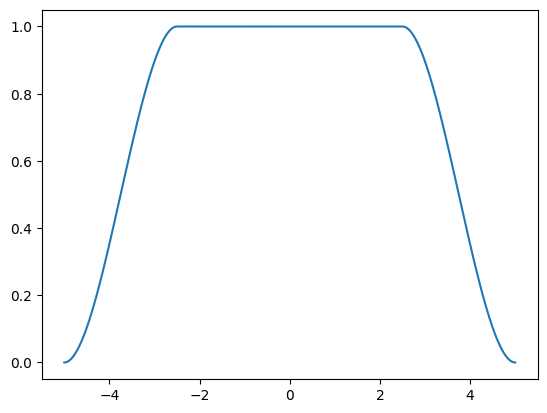

In [3]:
a = 5
part = 0.5
xs = np.linspace(-a, a, 1000)
cs = makeMaskPolynomCoeff(part * a, a)
ys = np.zeros_like(xs)
for idx, x in enumerate(xs):
    ys[idx] = maskFunction(x, cs, part*a)

maskMatr = diags([ys], [0], dtype=np.double).toarray()


plt.plot(xs, ys)
plt.show()


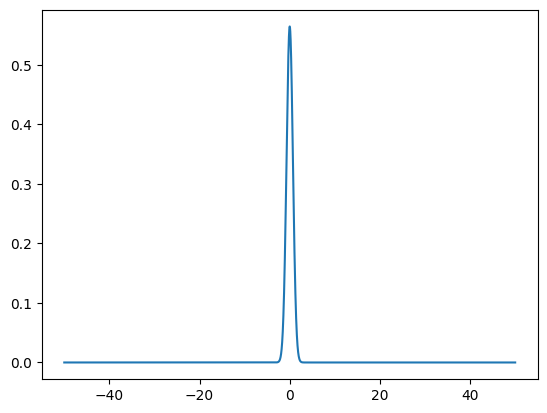

0.0 0
1.0 1
2.0 2
3.0 3
4.0 4
5.0 5
6.0 6
7.0 7
8.0 8
9.0 9
10.0 10


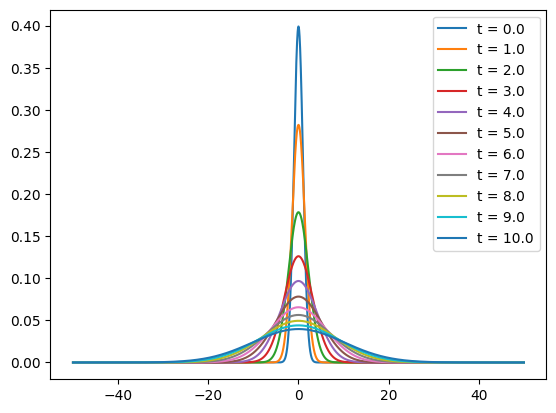

In [9]:
from scipy.integrate import quad as Integrate

numberOfPoints = 10000
boxBorder = 50
x_0 = 0
p_0 = 2
sigma = 1

xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
ys = squaredNorm(psi_0(xs, sigma, x_0, p_0))


plt.plot(xs, ys)
plt.show()

ts = np.linspace(0, 10, 11)
for t, ind in zip(ts, range(len(ts))):
    print(t, end=" ")
    print(ind)
    yst2 = squaredNorm(coordinateTimeExponent_v2(xs, t, 0))
    
    plt.plot(xs, yst2, label=("t = {:2.1f}".format(t)))

plt.legend()
plt.show()


In [10]:

numberOfPoints = 1000
boxBorder = 10
x_0 = 0
p_0 = 0.0
sigma = 1
maskPart = 0.9

xs = np.linspace(-boxBorder, boxBorder, numberOfPoints)
psi = coordinateTimeExponent_v2(xs, 0, 0)# psi_0(xs, sigma, x_0, p_0) 

filenames = []


H0_diag, H0_subdiag, V_diag = makeHamiltonian(numberOfPoints, boxBorder, v_0=0.0)
H = diags([H0_diag, H0_subdiag, H0_subdiag], [0, 1, -1], dtype=np.double).toarray()


cs = makeMaskPolynomCoeff(maskPart * boxBorder, boxBorder)
ys = np.zeros_like(xs)
for idx, x in enumerate(xs):
    ys[idx] = maskFunction(x, cs, maskPart * boxBorder)
M = diags([ys], [0], dtype=np.double).toarray()


t_lim = 50
n_ts = 100
ts = np.linspace(0, t_lim, n_ts)
t_step = t_lim / (n_ts - 1)
evolution_step = matrixExponent((-1j) * t_step * H)
psi_t = psi
for t, ind in zip(ts, range(len(ts))):
    y_theory = squaredNorm(coordinateTimeExponent_v2(xs, t, 0))
    
    # H_t = matrixExponent((-1j) * t * H)
    # psi_t = H_t @ psi

    # print(Integrate(lambda x: coordinateTimeExponent(x, t), -boxBorder, boxBorder))
    # print(Integrate(lambda x: psi_0(x, sigma, x_0, p_0), -boxBorder, boxBorder))
    
    plt.plot(xs, squaredNorm(psi_t), label=("Module".format(t)))
    plt.plot(xs, y_theory, 'r--', label="True solution")
    plt.plot(xs, psi_t.real, label=("Real".format(t)))
    plt.plot(xs, psi_t.imag, label=("Imag".format(t)))
    plt.title(("t = {:2.1f}".format(t)))
    
    plt.legend(loc='upper right')
    plt.ylim(-1, 1)
    psi_t = M @ ( evolution_step @ psi_t)
    # psi_t = evolution_step @ psi_t

    plt.savefig(("imgsGif/t_" + str(ind) + ".png"), dpi=300, bbox_inches='tight')
    filenames.append(("imgsGif/t_" + str(ind) + ".png"))
    plt.clf()




<Figure size 640x480 with 0 Axes>

In [11]:
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movieMask09_v2.gif', images)

C:\Users\kiril\AppData\Local\Temp\ipykernel_19344\2724781570.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
